# IMPORT

In [2]:
import os.path as osp
import glob
import sys
import torch
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_path = os.path.join(project_root, "FinalModels", "ESRGAN", "model", "RRDB_PSNR_x4.pth")
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
import time
from matplotlib import pyplot as plt
import tensorflow as tf

from FinalModels.ESRGAN.model import ESRGAN

# Set the project root and model path


# Initialize device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ESRGAN(model_path=model_path, device=device)

# Folder path for test images
folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"

# folder_path = "d:\\workspace\\ThesisProject\\DATASET\\TEST"

from skimage.metrics import structural_similarity as ssim
import lpips


# FUNCTIONS

In [4]:

def compute_ssim(hr_image, sr_image):
    return ssim(hr_image, sr_image, data_range=hr_image.max() - hr_image.min(), multichannel=True)

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img = transform(img).unsqueeze(0)  
    return img

def downscale_image(image, scale_factor=4):
    _, _, h, w = image.shape
    new_h, new_w = h // scale_factor, w // scale_factor
    image = F.interpolate(image, size=(new_h, new_w), mode='bicubic', align_corners=False)
    return image


lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

def evaluate_performance(hr_image, sr_image):
    """
    Evaluate the performance of super-resolution using multiple metrics.
    
    Parameters:
    - hr_image (torch.Tensor): High-resolution ground truth image (CxHxW, range [0,1])
    - sr_image (torch.Tensor): Super-resolved image (CxHxW, range [0,1])

    Returns:
    - metrics (dict): Dictionary containing PSNR, SSIM, LPIPS, and MOS
    """
    # Ensure images have the same spatial resolution
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)
    if hr_image.shape != sr_image.shape:
        print(f"Shape mismatch: HR {hr_image.shape}, SR {sr_image.shape}")
        return None  

    # Convert to single image if batch exists: [B, C, H, W] -> [C, H, W]
    if len(hr_image.shape) == 4:
        hr_image = hr_image.squeeze(0)  # Remove batch dim
        sr_image = sr_image.squeeze(0)

    # Convert PyTorch tensors to NumPy
    hr_np = hr_image.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC
    sr_np = sr_image.permute(1, 2, 0).cpu().numpy()

    # Compute MSE
    mse = F.mse_loss(sr_image, hr_image)
    if mse == 0:
        psnr = float('inf')  
    else:
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

    # Compute SSIM
    ssim_score = ssim(hr_np, sr_np, data_range=hr_np.max() - hr_np.min(), channel_axis=2)

    # Compute LPIPS (Convert tensors to 4D batch format)
    lpips_score = lpips_loss_fn(sr_image.unsqueeze(0), hr_image.unsqueeze(0)).item()

    # Simulated MOS Score (Optional: Replace with user study results)
    mos_score = (5 * (1 - lpips_score))  # Assumes LPIPS ~1 means worst, LPIPS ~0 means best

    # Return all metrics as a dictionary
    metrics = {
        "PSNR": psnr.item(),
        "SSIM": ssim_score,
        "LPIPS": lpips_score,
        "MOS (estimated)": mos_score
    }

    return metrics

def compare_images(hr_image, lr_image, sr_image, psnr):
    """Compare the images by displaying them and printing PSNR."""
    # sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)

    def process_image(img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert (3, H, W) to (H, W, 3)
        else:
            img = np.squeeze(img)  
            if img.ndim == 3 and img.shape[0] in [1, 3]:  # If channel-first, convert to channel-last
                img = np.transpose(img, (1, 2, 0))
        return img


    hr_image = hr_image.cpu().numpy() if isinstance(hr_image, torch.Tensor) else hr_image
    lr_image = lr_image.cpu().numpy() if isinstance(lr_image, torch.Tensor) else lr_image
    sr_image = sr_image.cpu().numpy() if isinstance(sr_image, torch.Tensor) else sr_image
    
    hr_image = np.clip(hr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    hr_image = process_image(hr_image)
    lr_image = process_image(lr_image)
    sr_image = process_image(sr_image)

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(1, 3)
    fig.tight_layout()

    # Plot Original Image
    plt.subplot(131)
    plot_image(hr_image, title="Original")
    
    # Plot Low-Resolution Image
    plt.subplot(132)
    plot_image(lr_image, title="x4 Bicubic")
    
    # Plot Super-Resolved Image
    plt.subplot(133)
    plot_image(sr_image, title="Super Resolution")
    
    plt.show(block=False)
    
def perform_super_resolution(image_path, model, device):
    """Performs super-resolution on an input image."""
    start = time.time()
    hr_image = preprocess_image(image_path).to(device)
    original = hr_image

    modes = {
        "Bilinear": F.interpolate(hr_image, size=(224, 224), mode='bilinear', align_corners=False),
        "Nearest": F.interpolate(hr_image, size=(224, 224), mode='nearest'),
        "Bicubic": F.interpolate(hr_image, size=(224, 224), mode='bicubic', align_corners=False),
        "Exact": F.interpolate(hr_image, size=(224, 224), mode='nearest-exact')
    }
    
    with torch.no_grad():
        enhanced_image = model(modes["Bicubic"])

    enhanced_image = F.interpolate(enhanced_image, size=(224, 224), mode='bilinear', align_corners=True)
    print(f"Time taken: {time.time() - start:.2f} seconds: SHAPE: {enhanced_image.shape}")
    # return enhanced_image, modes
    return original, enhanced_image, modes

def perform_bicubic(image_path, model, device):
    """Performs super-resolution on an input image."""
    start = time.time()
    hr_image = preprocess_image(image_path).to(device)
    original = hr_image

    hr_image = F.interpolate(hr_image, size=(224, 224), mode='bicubic')
    
    print(f"Time taken: {time.time() - start:.2f} seconds")
    return original, hr_image

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: d:\workspace\ThesisProject\venv\Lib\site-packages\lpips\weights\v0.1\alex.pth


# CASE 1: BICUBIC ONLY

In [6]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output  =  perform_bicubic(path, model, device)

    metrics = evaluate_performance(original, output)

    print(metrics)


1 1
Time taken: 0.02 seconds
{'PSNR': 80.5775146484375, 'SSIM': np.float32(0.99999714), 'LPIPS': 2.715009031817317e-06, 'MOS (estimated)': 4.999986424954841}
2 Balistapus Undulatus-notenhanced
Time taken: 0.00 seconds
{'PSNR': 72.88214111328125, 'SSIM': np.float32(0.9999946), 'LPIPS': 8.723640689822787e-07, 'MOS (estimated)': 4.999995638179655}
3 car
Time taken: 0.00 seconds
{'PSNR': 73.25090026855469, 'SSIM': np.float32(0.9999941), 'LPIPS': 4.760378487844719e-06, 'MOS (estimated)': 4.999976198107561}
4 Chaetodon Trifascialis
Time taken: 0.00 seconds
{'PSNR': 63.80390548706055, 'SSIM': np.float32(0.9999787), 'LPIPS': 1.2835113921028096e-05, 'MOS (estimated)': 4.999935824430395}
5 fish_000001229596_03681
Time taken: 0.00 seconds
{'PSNR': 78.5672607421875, 'SSIM': np.float32(0.9999977), 'LPIPS': 4.1359180613653734e-07, 'MOS (estimated)': 4.999997932040969}
6 fish_000013099594_03543
Time taken: 0.00 seconds
{'PSNR': 61.49251937866211, 'SSIM': np.float32(0.999965), 'LPIPS': 3.8696140109095

# CASE 2: NEAREST

In [50]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Nearest'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.56 seconds
=============PSNR Achieved: 30.978840==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.40 seconds
=============PSNR Achieved: 51.352306==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 34.236904==============
4 Chaetodon Trifascialis
Time taken: 0.37 seconds
=============PSNR Achieved: 27.995262==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
6 fish_000013099594_03543
Time taken: 0.37 seconds
=============PSNR Achieved: 24.793503==============
7 fish_000026690001_02685
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
8 fish_000065789596_04756
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
9 notenhanced
Time taken: 0.37 seconds
=============PSNR Achieved: 28.323526==============
10 notenhanced2
Time taken: 0.37 seconds
=============PSNR Achieved: 43.786999==============
11 notenhanced3
Time taken: 0.38 seconds
=============PSNR Achieved: 50.236275==

# CASE 3: BILINEAR ONLY

In [51]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Bilinear'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.77 seconds
=============PSNR Achieved: 39.477783==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.38 seconds
=============PSNR Achieved: 44.631348==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 45.441269==============
4 Chaetodon Trifascialis
Time taken: 0.38 seconds
=============PSNR Achieved: 33.924568==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
=============PSNR Achieved: 50.188805==============
6 fish_000013099594_03543
Time taken: 0.38 seconds
=============PSNR Achieved: 31.119644==============
7 fish_000026690001_02685
Time taken: 0.37 seconds
=============PSNR Achieved: 48.121094==============
8 fish_000065789596_04756
Time taken: 0.38 seconds
=============PSNR Achieved: 48.775333==============
9 notenhanced
Time taken: 0.38 seconds
=============PSNR Achieved: 35.747143==============
10 notenhanced2
Time taken: 0.38 seconds
=============PSNR Achieved: 35.717346==============
11 notenhanced3
Time taken

# CASE 4: Nearest Exact

In [3]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Exact'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.70 seconds
=============PSNR Achieved: 38.519455==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.44 seconds
PSNR: Infinite (identical images)
3 car
Time taken: 0.44 seconds
=============PSNR Achieved: 43.102688==============
4 Chaetodon Trifascialis
Time taken: 0.43 seconds
=============PSNR Achieved: 33.005253==============
5 fish_000001229596_03681
Time taken: 0.44 seconds
PSNR: Infinite (identical images)
6 fish_000013099594_03543
Time taken: 1.87 seconds
=============PSNR Achieved: 30.335114==============
7 fish_000026690001_02685
Time taken: 2.11 seconds
PSNR: Infinite (identical images)
8 fish_000065789596_04756
Time taken: 1.99 seconds
PSNR: Infinite (identical images)
9 notenhanced
Time taken: 1.78 seconds
=============PSNR Achieved: 35.085888==============
10 notenhanced2
Time taken: 1.80 seconds
PSNR: Infinite (identical images)
11 notenhanced3
Time taken: 2.05 seconds
=============PSNR Achieved: 54.706020==============
12 SAMPLE_LUTJANUS
Time

# CASE 5: BICUBIC + ESRGAN

In [3]:


idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes =  perform_super_resolution(path, model, device)

    metrics = evaluate_performance(original, output)
    print(metrics)
    # lr_image = downscale_image(original)




1 1
Time taken: 0.61 seconds: SHAPE: torch.Size([1, 3, 224, 224])
{'PSNR': 30.189144134521484, 'SSIM': np.float32(0.9799535), 'LPIPS': 0.012142276391386986, 'MOS (estimated)': 4.939288618043065}
2 Balistapus Undulatus-notenhanced
Time taken: 0.37 seconds: SHAPE: torch.Size([1, 3, 224, 224])
{'PSNR': 45.13731384277344, 'SSIM': np.float32(0.99823445), 'LPIPS': 0.00019603079999797046, 'MOS (estimated)': 4.99901984600001}
3 car
Time taken: 0.37 seconds: SHAPE: torch.Size([1, 3, 224, 224])
{'PSNR': 39.93037033081055, 'SSIM': np.float32(0.9934028), 'LPIPS': 0.0016185934655368328, 'MOS (estimated)': 4.991907032672316}
4 Chaetodon Trifascialis
Time taken: 0.37 seconds: SHAPE: torch.Size([1, 3, 224, 224])
{'PSNR': 35.07926559448242, 'SSIM': np.float32(0.97845864), 'LPIPS': 0.005670528393238783, 'MOS (estimated)': 4.971647358033806}
5 fish_000001229596_03681
Time taken: 0.36 seconds: SHAPE: torch.Size([1, 3, 224, 224])
{'PSNR': 51.173152923583984, 'SSIM': np.float32(0.99927884), 'LPIPS': 6.38911

: 

# PLOTTING THE DIFFERENCE

In [7]:
esrgan = torch.load('../saved_models/model/ESRGAN.pth', weights_only=False)

**ESRGAN + BICUBIC**

1 1
Time taken: 1.94 seconds: SHAPE: torch.Size([1, 3, 224, 224])


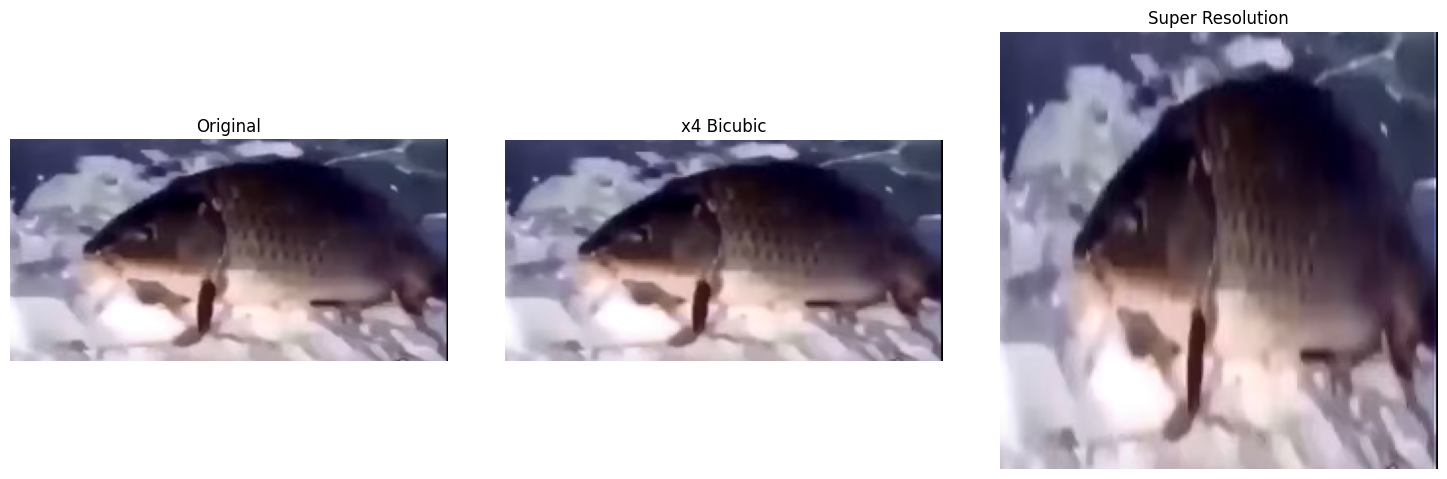

2 Balistapus Undulatus-notenhanced
Time taken: 1.72 seconds: SHAPE: torch.Size([1, 3, 224, 224])


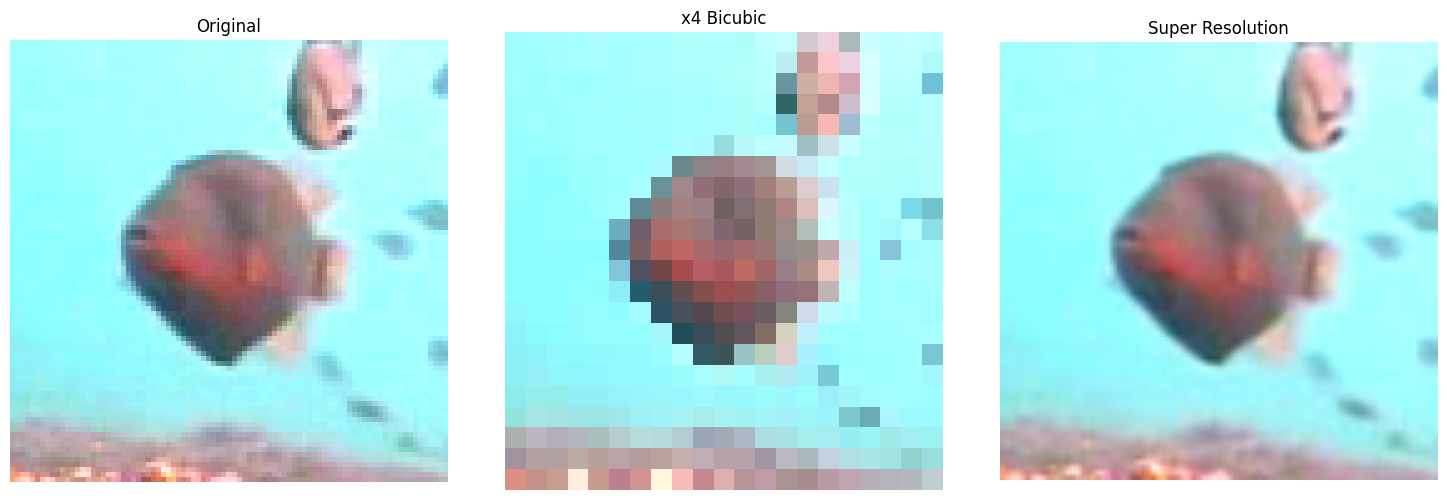

3 car
Time taken: 1.69 seconds: SHAPE: torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [44]:


idx = 0
for path in glob.glob(folder_path + "/*"):
    # for fish_class in glob.glob(path + "/*"):
        
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes =  perform_super_resolution(path, esrgan, device)

    psnr = evaluate_performance(original, output)

    lr_image = downscale_image(original)

    compare_images(original, lr_image, output, psnr)

        # IF SAVE IMAGE NO NEED
        # save_image2(img, "results/original", f'{idx}.png')
        # save_image2(output, "results/high", f'{idx}.png') 



# RESULT PSNR TEST

BICUBIC ONLY (HIGHEST IN MODES)
1 1
=============PSNR Achieved: 41.466770==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 56.170761==============
3 car
=============PSNR Achieved: 50.163975==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 38.104820==============
5 fish_000001229596_03681
=============PSNR Achieved: 61.991138==============
6 fish_000013099594_03543
=============PSNR Achieved: 35.272121==============
7 fish_000026690001_02685
=============PSNR Achieved: 59.949650==============
8 fish_000065789596_04756
=============PSNR Achieved: 62.545822==============
9 notenhanced
=============PSNR Achieved: 39.618000==============
10 notenhanced2
=============PSNR Achieved: 46.525799==============
11 notenhanced3
=============PSNR Achieved: 58.147869==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.205925==============
13 test_lowres
=============PSNR Achieved: 47.483276==============
14 test_lowres3
=============PSNR Achieved: 56.103230==============

NEAREST ONLY
1 1
=============PSNR Achieved: 31.044752==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 85.350372==============
3 car
=============PSNR Achieved: 35.543324==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 28.711269==============
5 fish_000001229596_03681
PSNR: Infinite (identical images)
6 fish_000013099594_03543
=============PSNR Achieved: 25.851030==============
7 fish_000026690001_02685
PSNR: Infinite (identical images)
8 fish_000065789596_04756
PSNR: Infinite (identical images)
9 notenhanced
=============PSNR Achieved: 30.415329==============
10 notenhanced2
=============PSNR Achieved: 80.077400==============
11 notenhanced3
=============PSNR Achieved: 50.859493==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.373062==============
13 test_lowres
=============PSNR Achieved: 36.000317==============
14 test_lowres3
=============PSNR Achieved: 43.697029==============


BILINEAR ONLY
1 1
=============PSNR Achieved: 41.491882==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 46.213120==============
3 car
=============PSNR Achieved: 45.998062==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 34.834724==============
5 fish_000001229596_03681
=============PSNR Achieved: 50.579647==============
6 fish_000013099594_03543
=============PSNR Achieved: 32.410587==============
7 fish_000026690001_02685
=============PSNR Achieved: 48.671055==============
8 fish_000065789596_04756
=============PSNR Achieved: 50.026886==============
9 notenhanced
=============PSNR Achieved: 36.351479==============
10 notenhanced2
=============PSNR Achieved: 36.267857==============
11 notenhanced3
=============PSNR Achieved: 57.194191==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.374054==============
13 test_lowres
=============PSNR Achieved: 46.918823==============
14 test_lowres3
=============PSNR Achieved: 52.869839==============

1 1 ESRGAN 224 PSNR
Time taken: 0.71 seconds
=============PSNR Achieved: 32.240833==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.39 seconds
=============PSNR Achieved: 60.285908==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 51.215584==============
4 Chaetodon Trifascialis
Time taken: 0.37 seconds
=============PSNR Achieved: 38.334896==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
=============PSNR Achieved: 66.877792==============
6 fish_000013099594_03543
Time taken: 0.41 seconds
=============PSNR Achieved: 32.837864==============
7 fish_000026690001_02685
Time taken: 0.39 seconds
=============PSNR Achieved: 64.426567==============
8 fish_000065789596_04756
Time taken: 0.39 seconds
=============PSNR Achieved: 67.100624==============
9 notenhanced
Time taken: 0.37 seconds
=============PSNR Achieved: 39.744598==============
10 notenhanced2
Time taken: 0.38 seconds
=============PSNR Achieved: 47.370663==============
11 notenhanced3
Time taken: 0.39 seconds
=============PSNR Achieved: 56.800991==============
12 SAMPLE_LUTJANUS
Time taken: 0.38 seconds
=============PSNR Achieved: 28.628653==============
13 test_lowres
Time taken: 0.39 seconds
=============PSNR Achieved: 47.293438==============
14 test_lowres3
Time taken: 0.37 seconds
=============PSNR Achieved: 56.408493==============


